In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/biomedical-text-publication-classification/alldata_1_for_kaggle.csv


In [2]:
pip install nltk


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


In [4]:
# استيراد المكتبات اللازمة
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS

# تحميل الموارد اللازمة من NLTK
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
data = pd.read_csv('../input/biomedical-text-publication-classification/alldata_1_for_kaggle.csv', encoding='latin1')
data.head()

,Unnamed: 0,0,a
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [6]:
data.shape

(7570, 3)

In [7]:
data.rename(columns = {'0':'target','a':'Text'},inplace= True)
data.head()

,Unnamed: 0,target,Text
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [8]:
data['target'].unique()

array(['Thyroid_Cancer', 'Colon_Cancer', 'Lung_Cancer'], dtype=object)

In [9]:
target_counts =data['target'].value_counts()
target_counts

target
Thyroid_Cancer    2810
Colon_Cancer      2580
Lung_Cancer       2180
Name: count, dtype: int64

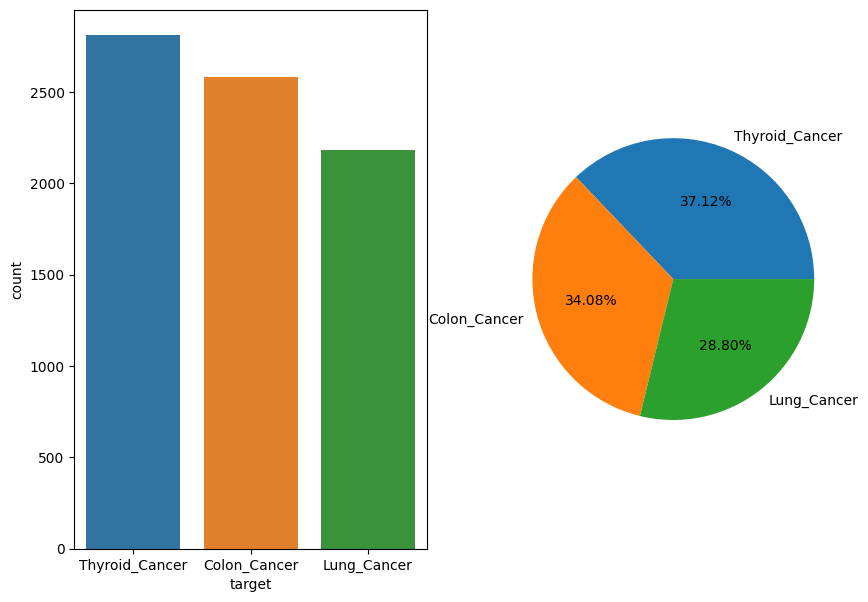

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
sns.barplot(x=target_counts.index, y=target_counts, ax=axes[0])

axes[1].pie(target_counts, labels=target_counts.keys(), autopct='%1.2f%%')
plt.show()

In [11]:
data['text_len'] = data['Text'].str.len()
data['word_count'] = data['Text'].apply(lambda x: len(str(x).split()))
data['unique_word_count'] = data['Text'].apply(lambda x: len(set(str(x).split())))
data['stop_word_count'] = data['Text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
data['url_count'] = data['Text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
data['punctuation_count'] = data['Text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [12]:
data.head()

,Unnamed: 0,target,Text,text_len,word_count,unique_word_count,stop_word_count,url_count,punctuation_count
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...,20707,2871,1098,814,1,4
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us...",17018,2494,994,815,0,70
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...,21622,2954,1384,797,0,7
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...,13860,1880,909,556,3,1
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...,23696,3037,1318,887,0,5


/tmp/ipykernel_22/2226561955.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(data['text_len'])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


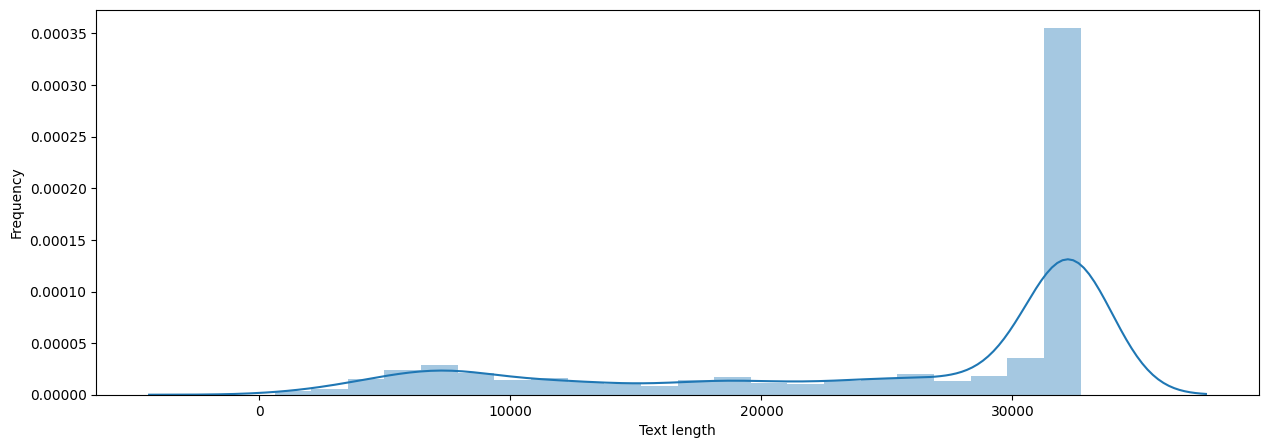

In [13]:
plt.figure(figsize=(15,5))
ax = sns.distplot(data['text_len'])
ax.set(xlabel='Text length', ylabel='Frequency')
plt.show()

/tmp/ipykernel_22/1519030579.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(num_1, shade=True, color = 'red').set_title('Kernel distribution of number of words')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_22/1519030579.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(num_2, shade=True, color = 'blue')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instea

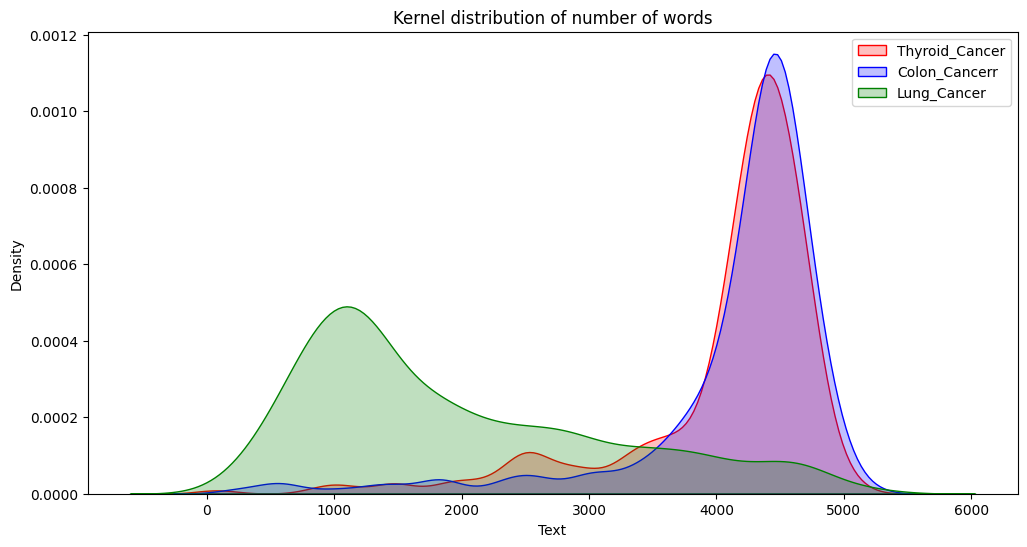

In [14]:
plt.figure(figsize=(12,6))
num_1 = data[data['target']== 'Thyroid_Cancer']['Text'].apply(lambda x: len(x.split()))
num_2 = data[data['target']== 'Colon_Cancer']['Text'].apply(lambda x: len(x.split()))
num_3 = data[data['target']== 'Lung_Cancer']['Text'].apply(lambda x: len(x.split()))
sns.kdeplot(num_1, shade=True, color = 'red').set_title('Kernel distribution of number of words')
sns.kdeplot(num_2, shade=True, color = 'blue')
sns.kdeplot(num_3, shade=True, color = 'green')

plt.legend(labels=['Thyroid_Cancer', 'Colon_Cancerr', 'Lung_Cancer'])

In [15]:
def wordcloud(target):
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=2000, height=1000).generate(" ".join(data[data['target']==target]['Text']))
    plt.figure(1,figsize=(15, 15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

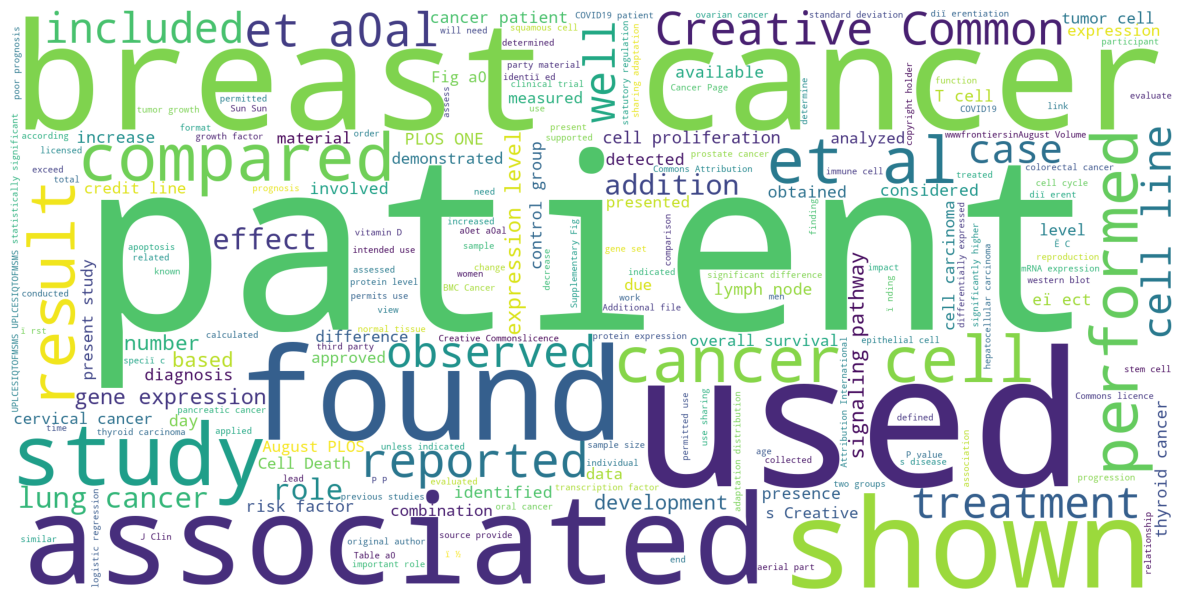

In [16]:
wordcloud('Thyroid_Cancer')

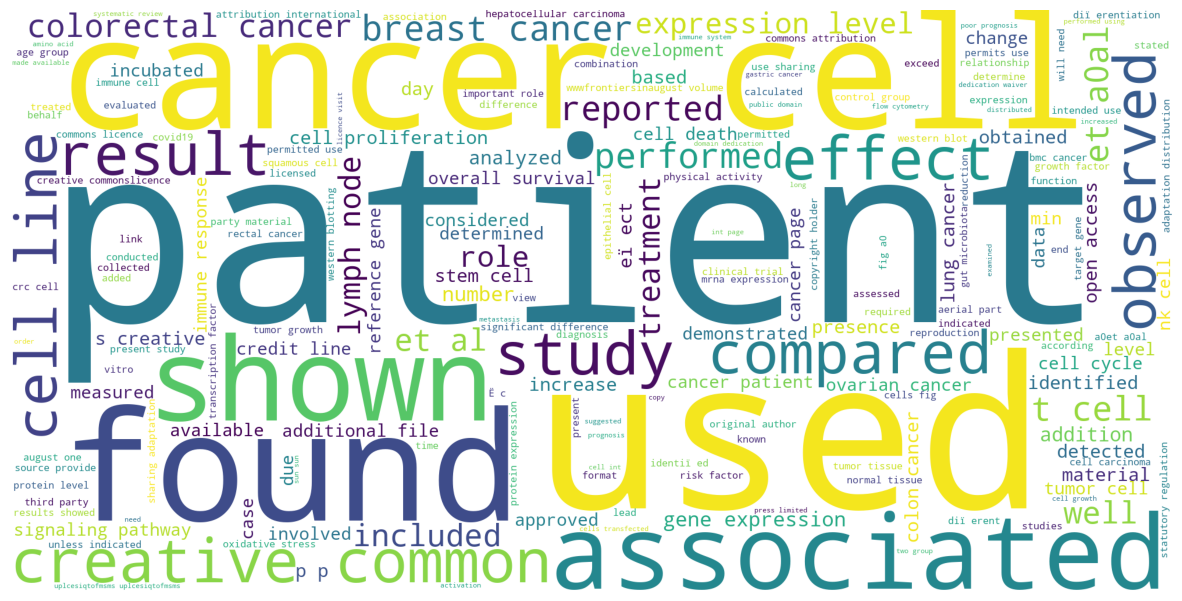

In [17]:
wordcloud('Colon_Cancer')

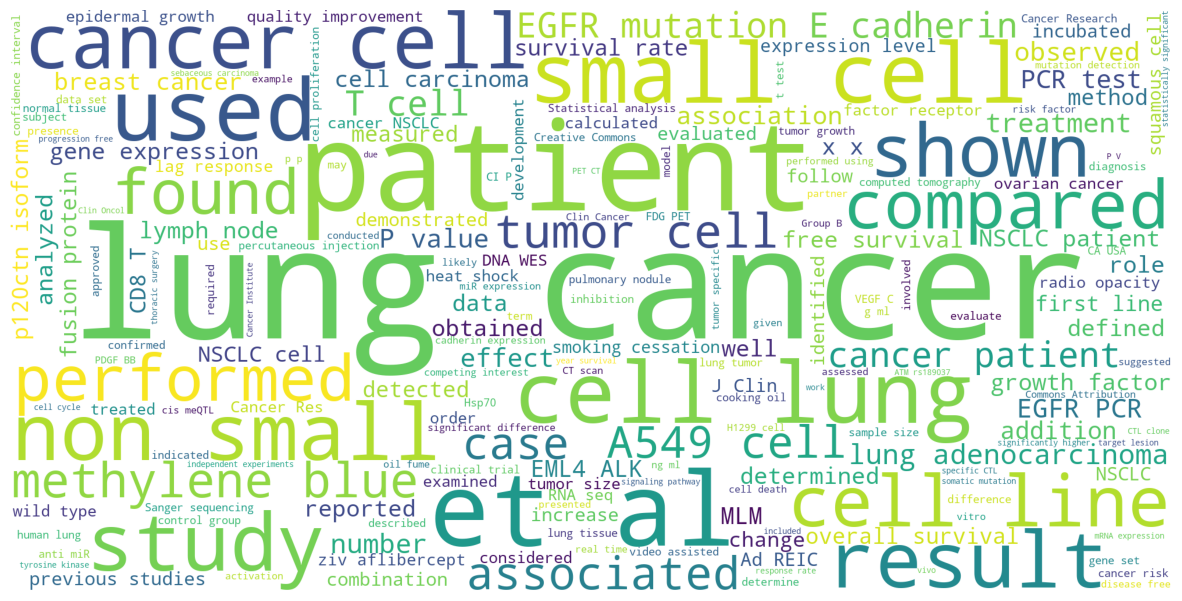

In [18]:
wordcloud('Lung_Cancer')

In [19]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 50

# Unigrams
Thyroid_Cancer_unigrams = defaultdict(int)
Colon_Cancer_unigrams = defaultdict(int)
Lung_Cancer_unigrams = defaultdict(int)

for doc in data['Text'][data['target'] == 'Thyroid_Cancer']:
    for word in generate_ngrams(doc):
        Thyroid_Cancer_unigrams[word] += 1

for doc in data['Text'][data['target'] == 'Colon_Cancer']:
    for word in generate_ngrams(doc):
        Colon_Cancer_unigrams[word] += 1

for doc in data['Text'][data['target'] == 'Lung_Cancer']:
    for word in generate_ngrams(doc):
        Lung_Cancer_unigrams[word] += 1
        

        
Thyroid_Cancer_unigrams = pd.DataFrame(sorted(Thyroid_Cancer_unigrams.items(), key=lambda x: x[1])[::-1])
Colon_Cancer_unigrams = pd.DataFrame(sorted(Colon_Cancer_unigrams.items(), key=lambda x: x[1])[::-1])
Lung_Cancer_unigrams = pd.DataFrame(sorted(Lung_Cancer_unigrams.items(), key=lambda x: x[1])[::-1])

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


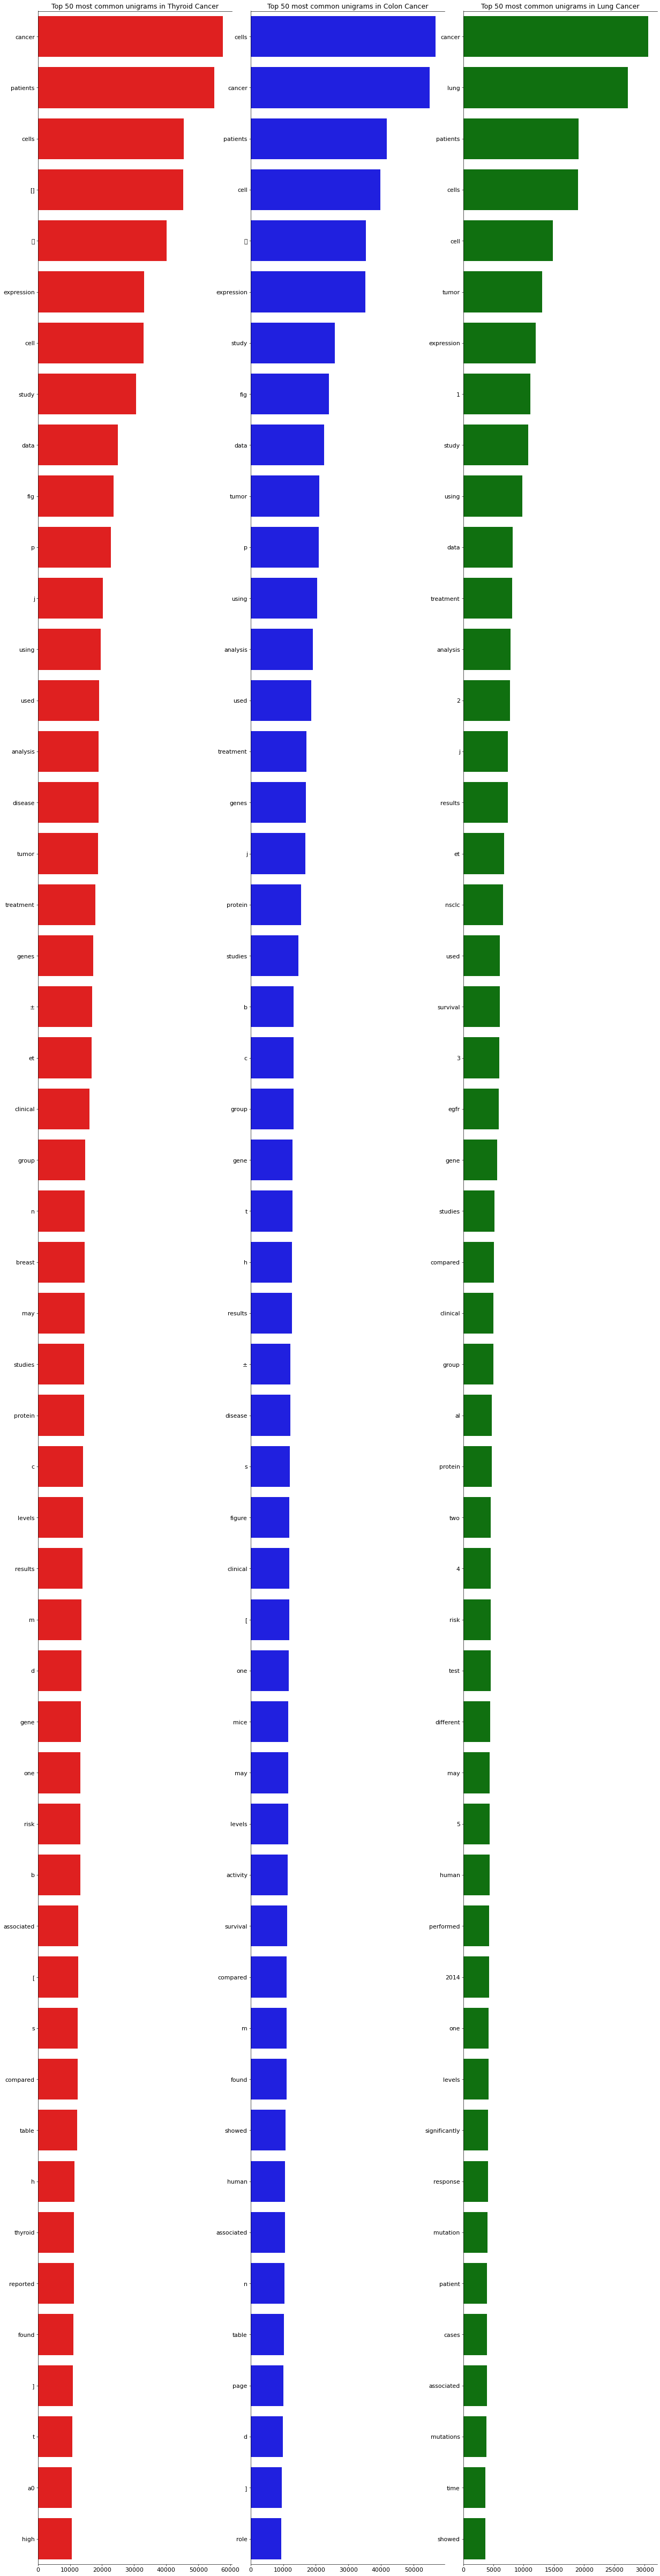

In [20]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 80), dpi=60)
plt.tight_layout()

sns.barplot(y=Thyroid_Cancer_unigrams[0].values[:N], x=Thyroid_Cancer_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=Colon_Cancer_unigrams[0].values[:N], x=Colon_Cancer_unigrams[1].values[:N], ax=axes[1], color='blue')
sns.barplot(y=Lung_Cancer_unigrams[0].values[:N], x=Lung_Cancer_unigrams[1].values[:N], ax=axes[2], color='green')


for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Thyroid Cancer', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Colon Cancer', fontsize=15)
axes[2].set_title(f'Top {N} most common unigrams in Lung Cancer', fontsize=15)

plt.show()

# Preprocessing and feature engineering
Drop the column unnamed as it is not useful

Rename the column into readable form 


 
Steps : 


1) Converting into lower case

2) Tokenizing : spliting sentences into words

3) Removing special characters

4) Removing stopwords and punctuations

5) Stemming: converting into root words

6) Join to make sentences

In [21]:
#Drop the column unnamed as it is not useful:
data.drop('Unnamed: 0',axis=1,inplace=True)

In [22]:
#Rename the column into readable form :
data.rename({'0':'cancer','a':'text'},axis=1,inplace=True)
data.tail()

,target,Text,text_len,word_count,unique_word_count,stop_word_count,url_count,punctuation_count
7565,Colon_Cancer,we report the case of a 24yearold man who pres...,11219,1429,660,399,0,11
7566,Colon_Cancer,among synchronous colorectal cancers scrcs rep...,9085,1252,585,388,1,3
7567,Colon_Cancer,the heterogeneity of cancer cells is generally...,32373,4510,1473,1282,0,16
7568,Colon_Cancer,"""adipogenesis is the process through which mes...",32390,4051,1407,1281,0,29
7569,Colon_Cancer,the periparturient period is one of the most c...,32639,4385,1212,1336,1,6


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7570 entries, 0 to 7569
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   target             7570 non-null   object
 1   Text               7570 non-null   object
 2   text_len           7570 non-null   int64 
 3   word_count         7570 non-null   int64 
 4   unique_word_count  7570 non-null   int64 
 5   stop_word_count    7570 non-null   int64 
 6   url_count          7570 non-null   int64 
 7   punctuation_count  7570 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 473.2+ KB


In [24]:
data.isnull().sum()

target               0
Text                 0
text_len             0
word_count           0
unique_word_count    0
stop_word_count      0
url_count            0
punctuation_count    0
dtype: int64

In [25]:
#converting into lowercase
data['Text']=data['Text'].str.lower()

In [26]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [28]:
#break into words
nltk.download('punkt')
data['Text']=data['Text'].apply(lambda x:word_tokenize(x))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
#removing special character
def remove_special_char(list):
    y=[]
    for string in list:
        if string.isalnum():
            y.append(string)
    return y
data['Text']=data['Text'].apply(lambda x:remove_special_char(x))

In [30]:
import pandas as pd
import string
from nltk.corpus import stopwords

# تأكد من تحميل قائمة الكلمات الشائعة مرة واحدة فقط
stop_words = set(stopwords.words('english'))

# دالة لإزالة الكلمات الشائعة وعلامات الترقيم
def useful_words(word_list):
    return [word for word in word_list if word not in stop_words and word not in string.punctuation]

# تطبيق الدالة على عمود النصوص
data['Text'] = data['Text'].apply(lambda x: useful_words(x) if isinstance(x, list) else [])


In [31]:
from nltk.stem import PorterStemmer
import pandas as pd

ps = PorterStemmer()

def stemming(text):
    if isinstance(text, list):  # تحقق مما إذا كان المدخل قائمة
        stemmed_words = []
        for item in text:  # لكل عنصر في القائمة
            words = item.split()  # تقسيم النص إلى كلمات
            stemmed_words.extend([ps.stem(word) for word in words])  # تطبيق التجذير
        return ' '.join(stemmed_words)  # إعادة تجميع الكلمات
    else:
        # إذا كان المدخل نصًا فرديًا، قم بتطبيق التجذير عليه
        words = text.split()
        stemmed_words = [ps.stem(word) for word in words]
        return ' '.join(stemmed_words)

# تطبيق الدالة على العمود
data['Text'] = data['Text'].map(stemming)


In [32]:
#join the words   
data  [ 'Text' ]  = data  [ 'Text' ]  .apply  ( lambda   x  : ""  .join  (  x  ))

In [33]:
data

,target,Text,text_len,word_count,unique_word_count,stop_word_count,url_count,punctuation_count
0,Thyroid_Cancer,thyroid surgeri children singl institut osama ...,20707,2871,1098,814,1,4
1,Thyroid_Cancer,adopt strategi use prior year base four exclus...,17018,2494,994,815,0,70
2,Thyroid_Cancer,coronari arterybypass graft thrombosi mutation...,21622,2954,1384,797,0,7
3,Thyroid_Cancer,solitari plasmacytoma sp skull uncommon clinic...,13860,1880,909,556,3,1
4,Thyroid_Cancer,studi aim investig serum matrix metalloprotein...,23696,3037,1318,887,0,5
...,...,...,...,...,...,...,...,...
7565,Colon_Cancer,report case 24yearold man present chief compla...,11219,1429,660,399,0,11
7566,Colon_Cancer,among synchron colorect cancer scrc report pre...,9085,1252,585,388,1,3
7567,Colon_Cancer,heterogen cancer cell gener accept astem celll...,32373,4510,1473,1282,0,16
7568,Colon_Cancer,adipogenesi process mesenchymalstem cell msc c...,32390,4051,1407,1281,0,29


In [34]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [35]:
#Remove duplicate values to avoid overfitting 
data=data.drop_duplicates()

In [36]:
import pickle

#Vectorize the data by using tfidf for text , and y = Target
cv=CountVectorizer(max_features=3000)
tfidf=TfidfVectorizer(max_features=4600)
x=tfidf.fit_transform(data['Text']).toarray()
y=data['target'].values
with open('tfidf.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

In [37]:
#Divide the data into  train and test data 
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=28,stratify=y)

In [38]:
GaussianNBModel = GaussianNB()
MultinomialNBModel = MultinomialNB(alpha=1.0)
BernoulliNBModel = BernoulliNB(alpha=1.0,binarize=1)
LogisticRegressionModel = LogisticRegression(penalty='l2',solver='sag',C=1.0,random_state=33)
RandomForestClassifierModel = RandomForestClassifier(criterion = 'gini',n_estimators=300,max_depth=7,random_state=33) 
GBCModel = GradientBoostingClassifier(n_estimators=100,max_depth=3,random_state=33) 
QDAModel = QuadraticDiscriminantAnalysis(tol=0.0001)
SVCModel = SVC(kernel= 'rbf',max_iter=100,C=1.0,gamma='auto')
DecisionTreeClassifierModel = DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=33)
KNNClassifierModel = KNeighborsClassifier(n_neighbors= 5,weights ='uniform',algorithm='auto') 

Models = [GaussianNBModel,KNNClassifierModel,MultinomialNBModel,
          BernoulliNBModel,LogisticRegressionModel,RandomForestClassifierModel,
          GBCModel,QDAModel,SVCModel,DecisionTreeClassifierModel]

In [39]:
ModelsScore = {}
for Model in Models : 
    print(f'for Model {str(Model).split("(")[0]}')
    Model.fit(X_train, y_train)
    print(f'Train Score is : {Model.score(X_train, y_train)}')
    print(f'Test Score is : {Model.score(X_test, y_test)}')
    y_pred = Model.predict(X_test)
    ClassificationReport = classification_report(y_test,y_pred)
    print('Classification Report is : \n', ClassificationReport )
    print(f'Precision value is  : {ClassificationReport.split()[19]}')
    print(f'Recall value is  : {ClassificationReport.split()[20]}')
    print(f'F1 Score value is  : {ClassificationReport.split()[21]}')
    ModelsScore[str(Model).split("(")[0]] = [ClassificationReport.split()[19],
                                             ClassificationReport.split()[20],ClassificationReport.split()[21]]
    print('=================================================')

for Model GaussianNB
Train Score is : 0.9705488621151271
Test Score is : 0.7068273092369478
Classification Report is : 
                 precision    recall  f1-score   support

  Colon_Cancer       0.45      0.54      0.49        65
   Lung_Cancer       0.99      0.96      0.97       113
Thyroid_Cancer       0.52      0.46      0.49        71

      accuracy                           0.71       249
     macro avg       0.66      0.65      0.65       249
  weighted avg       0.72      0.71      0.71       249

Precision value is  : accuracy
Recall value is  : 0.71
F1 Score value is  : 249
for Model KNeighborsClassifier
Train Score is : 0.8273092369477911
Test Score is : 0.6867469879518072
Classification Report is : 
                 precision    recall  f1-score   support

  Colon_Cancer       0.55      0.45      0.49        65
   Lung_Cancer       0.80      0.95      0.87       113
Thyroid_Cancer       0.56      0.49      0.52        71

      accuracy                           0.69  

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Score is : 0.9611780455153949
Test Score is : 0.7630522088353414
Classification Report is : 
                 precision    recall  f1-score   support

  Colon_Cancer       0.60      0.55      0.58        65
   Lung_Cancer       0.93      0.99      0.96       113
Thyroid_Cancer       0.61      0.59      0.60        71

      accuracy                           0.76       249
     macro avg       0.71      0.71      0.71       249
  weighted avg       0.75      0.76      0.76       249

Precision value is  : accuracy
Recall value is  : 0.76
F1 Score value is  : 249
for Model RandomForestClassifier
Train Score is : 0.9946452476572959
Test Score is : 0.8112449799196787
Classification Report is : 
                 precision    recall  f1-score   support

  Colon_Cancer       0.67      0.65      0.66        65
   Lung_Cancer       0.97      1.00      0.98       113
Thyroid_Cancer       0.68      0.66      0.67        71

      accuracy                           0.81       249
     macro

/opt/conda/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Train Score is : 1.0
Test Score is : 0.321285140562249
Classification Report is : 
                 precision    recall  f1-score   support

  Colon_Cancer       0.27      0.46      0.34        65
   Lung_Cancer       0.94      0.15      0.26       113
Thyroid_Cancer       0.28      0.46      0.35        71

      accuracy                           0.32       249
     macro avg       0.50      0.36      0.32       249
  weighted avg       0.58      0.32      0.31       249

Precision value is  : accuracy
Recall value is  : 0.32
F1 Score value is  : 249
for Model SVC


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train Score is : 0.8888888888888888
Test Score is : 0.7389558232931727
Classification Report is : 
                 precision    recall  f1-score   support

  Colon_Cancer       0.62      0.38      0.48        65
   Lung_Cancer       1.00      0.91      0.95       113
Thyroid_Cancer       0.53      0.79      0.63        71

      accuracy                           0.74       249
     macro avg       0.72      0.69      0.69       249
  weighted avg       0.77      0.74      0.74       249

Precision value is  : accuracy
Recall value is  : 0.74
F1 Score value is  : 249
for Model DecisionTreeClassifier
Train Score is : 0.8447121820615796
Test Score is : 0.7991967871485943
Classification Report is : 
                 precision    recall  f1-score   support

  Colon_Cancer       0.59      0.85      0.70        65
   Lung_Cancer       0.91      0.89      0.90       113
Thyroid_Cancer       0.96      0.61      0.74        71

      accuracy                           0.80       249
     macro